# Shopify Winter 2022 Data Science Challenge by Oliver Pan

## Question 1

Before we begin, let's take a look at our data and the problem we are trying to solve.

#### Import data & libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [61]:
sneakers_data = pd.read_csv(r'C:\Users\Oliver\Desktop\winter.csv')

#### Exploratory Data Analysis (EDA)

In [62]:
# Quick look at the dataset
sneakers_data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [63]:
# Check to ensure we are seeing all columns
sneakers_data.columns

Index(['order_id', 'shop_id', 'user_id', 'order_amount', 'total_items',
       'payment_method', 'created_at'],
      dtype='object')

In [64]:
# Check the structure of the dataset
sneakers_data.shape

(5000, 7)

In [65]:
# Viewing descriptive statistics of two columns
sneakers_data[['order_amount', 'total_items']].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


Just as we suspected, the average order_amount seems to be quite high, given that shoes are affordable. Let's investigate a bit more to see why that might be.

In [66]:
# Ensure no NULL data
null_check = sneakers.isnull().sum().to_frame()
null_check.columns = ['number_null']
null_check

,number_null
order_id,0
shop_id,0
user_id,0
order_amount,0
total_items,0
payment_method,0
created_at,0


After our EDA, we can now start with our resolutions to this analysis problem

## a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

#### Observations

- It seems like our data is skewed, as mentioned previously. 
- Often when looking at averages, one anomaly can often make the data appear different. 
- We also see further evidence when we see the standard deviation, which measures variability across data

#### Hence, let's look at another way to evaluate this data

### Proposal: Remove Anomalies

In [67]:
# Make 2 copies to work with
sneakers_p1 = sneakers_data.copy()
sneakers_p2 = sneakers_data.copy()

Before we remove anomalies, I want to scale the purchases to 1 item, to get a better understanding of order_amount

In [68]:
# Filter necessary columns for analysis
sneakers_p1 = sneakers_p1[['shop_id', 'order_amount', 'total_items']]

In [69]:
# Scale purchases to give even weight to total_items
sneakers_p1['orders_to_one'] = sneakers_p1['order_amount'] / sneakers_p1['total_items']

In [70]:
sneakers_p1.head()

,shop_id,order_amount,total_items,orders_to_one
0,53,224,2,112.0
1,92,90,1,90.0
2,44,144,1,144.0
3,18,156,1,156.0
4,18,156,1,156.0


In [71]:
sneakers_p1[['orders_to_one']].describe()

,orders_to_one
count,5000.000000
mean,387.742800
std,2441.963725
min,90.000000
25%,133.000000
50%,153.000000
75%,169.000000
max,25725.000000


#### Part 1: Shop 78 Analysis (Overpriced)

Let's look at each individual shop since the average is still very high

In [72]:
# Group by shop_id, averaging purchases per shop
p1_grouped = sneakers_p1.groupby(sneakers_p1['shop_id'])['orders_to_one'].mean().reset_index().sort_values(by=['orders_to_one'], ascending = False)
p1_grouped.head(10)

,shop_id,orders_to_one
77,78,25725.0
41,42,352.0
11,12,201.0
88,89,196.0
98,99,195.0
49,50,193.0
37,38,190.0
50,51,187.0
5,6,187.0
10,11,184.0


#### Therefore, we reveal that shop 78 is overpricing, as to why the average is still high.

In [73]:
# Average before removing shop 78 from calculation
round(np.mean(sneakers_p1['orders_to_one']), 2)

387.74

<AxesSubplot:title={'center':'Boxplot of orders_to_one, before removing shop 78'}, xlabel='orders_to_one'>

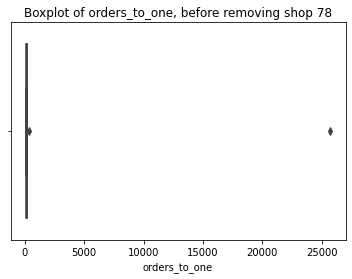

In [74]:
# Visual Representation of Anomalies
plt.title('Boxplot of orders_to_one, before removing shop 78')
sns.boxplot(p1_grouped['orders_to_one'])

In [75]:
# Average after removing shop 78 from calculation
round(np.mean(sneakers_p1[sneakers_p1['shop_id'] != 78]['orders_to_one']), 2)

152.48

<AxesSubplot:title={'center':'Boxplot of orders_to_one, after removing shop 78'}, xlabel='orders_to_one'>

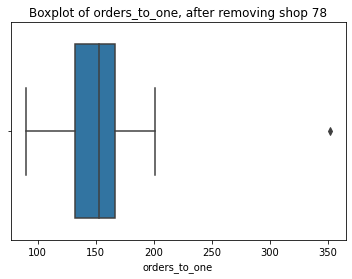

In [76]:
plt.title('Boxplot of orders_to_one, after removing shop 78')
sns.boxplot(p1_grouped[p1_grouped['shop_id'] != 78]['orders_to_one'])

To conclude, it looks like our shoe is affordable, at an average of $152.48 per shoe across 99 stores

#### Part 2: Shop 42 Analysis (Bulk Sellers)

Let's backtrack once more and look at our dataset previously. One caveat to looking at orders_to_one is that we disregard cases where price seems correct, but amount of shoes_sold is anomalous.

In [18]:
sneakers_p2['total_items'].value_counts()

2       1832
1       1830
3        941
4        293
5         77
2000      17
6          9
8          1
Name: total_items, dtype: int64

#### Which store is selling 2000 items per order?

In [19]:
sneakers_p2[sneakers_p2['total_items'] == 2000]['shop_id'].unique()

array([42], dtype=int64)

#### Is this the shop 42's issue or is it a customer that is driving high order amounts?

In [20]:
sneakers_p2 = sneakers_p2[['shop_id', 'user_id', 'order_amount', 'total_items']]

In [21]:
sneakers_p2[sneakers_p2['shop_id'] == 42].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
40,42,793,352,1
60,42,607,704000,2000
308,42,770,352,1
409,42,904,704,2


In [22]:
sneakers_p2[sneakers_p2['user_id'] == 607].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
60,42,607,704000,2000
520,42,607,704000,2000
1104,42,607,704000,2000
1362,42,607,704000,2000


The reason we remove shop 42 although the anomalies are caused by customer 607 is because as a business, we cannot control how the consumer spends. We can only change how the business acts, removing this customer to strengthen our model for a better understanding of the problem.

#### After removing both shop 78 and 42.....

In [42]:
# Average order amount
round(np.mean(sneakers_p1[(sneakers_p1['shop_id'] != 42) & (sneakers_p1['shop_id'] != 78)])['order_amount'], 2)

300.16

In [79]:
# Average number of items purchased per order
round(np.mean(sneakers_p1[(sneakers_p1['shop_id'] != 42) & (sneakers_p1['shop_id'] != 78)])['total_items'], 3)

1.996

In [43]:
# Scaled to 1 item
round(np.mean(sneakers_p1[(sneakers_p1['shop_id'] != 42) & (sneakers_p1['shop_id'] != 78)])['orders_to_one'], 2)

150.4

Now, we see the data in a better lens. It seems like shoes are much more affordable after data cleansing (removing 2 shops)

## b. What metric would you report for this dataset?

After our previous analysis, we found the average wasn't the best indicator of our analysis. It seems like we weren't considering anomalous situations, which can often skew AOV.

In [27]:
# Looking at our order_amount once again
sneakers_data['order_amount'].describe().to_frame().round(2)

,order_amount
count,5000.00
mean,3145.13
std,41282.54
min,90.00
25%,163.00
50%,284.00
75%,390.00
max,704000.00


Going back, we found that the average order amount is $300.16. This was after we removed our anomolies. But what if there was a situation where we DIDN'T want to remove any data?

- Without any removal of shops, we can look at the data through percentiles. 

#### Hence, of the percentiles we look at, 50% or MEDIAN is the metric that would best represent the data.

## c. What is its value?

In [81]:
# Median of dataset
np.median(sneakers_data['order_amount'])

284.0

In [87]:
# With shops (78 and 42 taken out)
np.median(sneakers_data[(sneakers_data['shop_id'] != 42) & (sneakers_data['shop_id'] != 78)]['order_amount'])

284.0

Using our numpy function, or table above, we conclude that our median is $284 which represents the data accurately. (Very similar to our AOV when we took out shops 78 and 42)